In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = True

run2_input = False

omtf_input = False

displ_input = True

model_name = 'model'

epochs = 300

batch_size = 4096

tile = 6

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import nlayers, nvariables
  from nn_data_omtf import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  model_name = 'model_omtf'
  
  epochs = 450
  
  tile = 11

# ______________________________________________________________________________
if displ_input:
  model_name = 'model_displ'
  
  epochs = 360

### Import data

In [3]:
infile_muon_no_displ = '../test7/histos_tba_no_displ.24.npz'

infile_muon_displ = '../test7/histos_tba_displ.24.npz'

nentries = 1520000

In [4]:
from sklearn.model_selection import train_test_split

from nn_encode import Encoder

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
  try:
    logger.info('Loading muon data from {0} ...'.format(filename))
    loaded = np.load(filename)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    the_variables = the_variables[:nentries]
    the_parameters = the_parameters[:nentries]
    logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
    logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
  except:
    logger.error('Failed to load data from file: {0}'.format(filename))

  assert(the_variables.shape[0] == the_parameters.shape[0])

  encoder = Encoder(the_variables, the_parameters, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
  if correct_for_eta:
    x, y, dxy, dz, w, x_mask, x_road = encoder.get_x(), encoder.get_y_corrected_for_eta(), encoder.get_dxy(), encoder.get_dz(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  else:
    x, y, dxy, dz, w, x_mask, x_road = encoder.get_x(), encoder.get_y(), encoder.get_dxy(), encoder.get_dz(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
  logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))
  assert(np.isfinite(x).all())
  return x, y, dxy, dz, w, x_mask, x_road


def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
  x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

  # Split dataset in training and testing
  x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
  logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

  # Check for cases where the number of events in the last batch could be too few
  validation_split = 0.1
  train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

In [5]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
      muon_data_split(infile_muon_no_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

[INFO    ] Loading muon data from ../test7/histos_tba_no_displ.24.npz ...
[INFO    ] Loaded the variables with shape (1520000, 179)
[INFO    ] Loaded the parameters with shape (1520000, 6)
[INFO    ] Loaded the encoded variables with shape (1520000, 36)
[INFO    ] Loaded the encoded parameters with shape (1520000,)
[INFO    ] Loaded # of training and testing events: (1041200, 478800)


In [6]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

[INFO    ] Loading muon data from ../test7/histos_tba_displ.24.npz ...
[INFO    ] Loaded the variables with shape (1520000, 179)
[INFO    ] Loaded the parameters with shape (1520000, 6)
[INFO    ] Loaded the encoded variables with shape (1520000, 36)
[INFO    ] Loaded the encoded parameters with shape (1520000,)
[INFO    ] Loaded # of training and testing events: (1041200, 478800)


In [7]:
from nn_models import K, Sequential, Dense, BatchNormalization, Activation, \
                      regularizers, optimizers, huber_loss, ModelCheckpoint

def huber_loss2(y_true, y_pred, delta=1.345):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  #xx = K.switch(x < delta, squared_loss, absolute_loss)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
  return K.mean(xx, axis=-1)

def huber_loss3(y_true, y_pred, delta=3.80):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  #xx = K.switch(x < delta, squared_loss, absolute_loss)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
  return K.mean(xx, axis=-1)

def create_model_sequential_bn2(nvariables, lr=0.001, clipnorm=10., nodes1=64, nodes2=32, nodes3=16, nodes4=0, nodes5=0, outnodes=1,
                                l1_reg=0.0, l2_reg=0.0, use_bn=True, use_dropout=False):
  # Adding 1 BN layer right after the input layer
  regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)

  model = Sequential()
  if use_bn: model.add(BatchNormalization(input_shape=(nvariables,), epsilon=1e-4, momentum=0.9))

  model.add(Dense(nodes1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
  if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
  model.add(Activation('tanh'))
  if nodes2:
    model.add(Dense(nodes2, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
    if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
    model.add(Activation('tanh'))
    if nodes3:
      model.add(Dense(nodes3, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
      if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
      model.add(Activation('tanh'))
      if nodes4:
        model.add(Dense(nodes4, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
        if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
        model.add(Activation('tanh'))
        if nodes5:
          model.add(Dense(nodes5, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
          if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
          model.add(Activation('tanh'))

  # Output node
  model.add(Dense(outnodes, activation='linear', kernel_initializer='glorot_uniform'))

  # Set loss and optimizers
  adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
  model.compile(optimizer=adam, loss=huber_loss2, metrics=['acc'])
  model.summary()
  return model

def create_model_sequential_bn3(nvariables, lr=0.001, clipnorm=10., nodes1=64, nodes2=32, nodes3=16, nodes4=0, nodes5=0, outnodes=1,
                                l1_reg=0.0, l2_reg=0.0, use_bn=True, use_dropout=False):
  # Adding 1 BN layer right after the input layer
  regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)

  model = Sequential()
  if use_bn: model.add(BatchNormalization(input_shape=(nvariables,), epsilon=1e-4, momentum=0.9))

  model.add(Dense(nodes1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
  if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
  model.add(Activation('tanh'))
  if nodes2:
    model.add(Dense(nodes2, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
    if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
    model.add(Activation('tanh'))
    if nodes3:
      model.add(Dense(nodes3, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
      if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
      model.add(Activation('tanh'))
      if nodes4:
        model.add(Dense(nodes4, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
        if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
        model.add(Activation('tanh'))
        if nodes5:
          model.add(Dense(nodes5, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
          if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
          model.add(Activation('tanh'))

  # Output node
  model.add(Dense(outnodes, activation='linear', kernel_initializer='glorot_uniform'))

  # Set loss and optimizers
  adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
  model.compile(optimizer=adam, loss=huber_loss3, metrics=['acc'])
  model.summary()
  return model

In [8]:
logger.info('Using reg_pt_scale: {0}'.format(reg_pt_scale))
logger.info('Using reg_dxy_scale: {0}'.format(reg_dxy_scale))

[INFO    ] Using reg_pt_scale: 100.0
[INFO    ] Using reg_dxy_scale: 0.4


In [9]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

### Training (Part I)

Try different cases:
- (a) Train with prompt muons, apply to prompt muons
- (b) Train with displaced muons, apply to displaced muons
- (c) Train with displaced muons, apply to prompt muons
- (d) Train with prompt muons, apply to displaced muons

In [10]:
# Trial 1: nodes1=50, nodes2=40, nodes3=30, nodes4=20
# Trial 2: nodes1=30, nodes2=25, nodes3=20

model = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=30, nodes2=25, nodes3=20)

modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 36)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 25)                100       
_________________________________________________________________
activation_2 (Activation)    (None, 25)                0         
__________

In [11]:
logger.info('Begin training ...')
history = model.fit(x_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

model.load_weights('model_bchk_weights.h5')

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 360/360 - loss: 3.35357145952 - val_loss: 3.23575250856


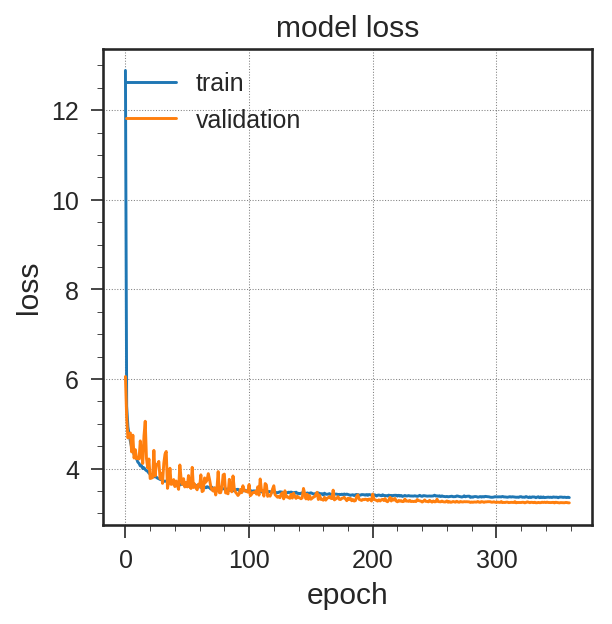

In [12]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
model_displ = create_model_sequential_bn3(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=30, nodes2=25, nodes3=20)

modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 36)                144       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1080      
_________________________________________________________________
batch_normalization_6 (Batch (None, 30)                120       
_________________________________________________________________
activation_4 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                750       
_________________________________________________________________
batch_normalization_7 (Batch (None, 25)                100       
_________________________________________________________________
activation_5 (Activation)    (None, 25)                0         
__________

In [14]:
logger.info('Begin training ...')
history = model_displ.fit(x_train_displ, y_train_displ,
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

model_displ.load_weights('model_bchk_weights.h5')

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 360/360 - loss: 16.3503836996 - val_loss: 15.2875822333


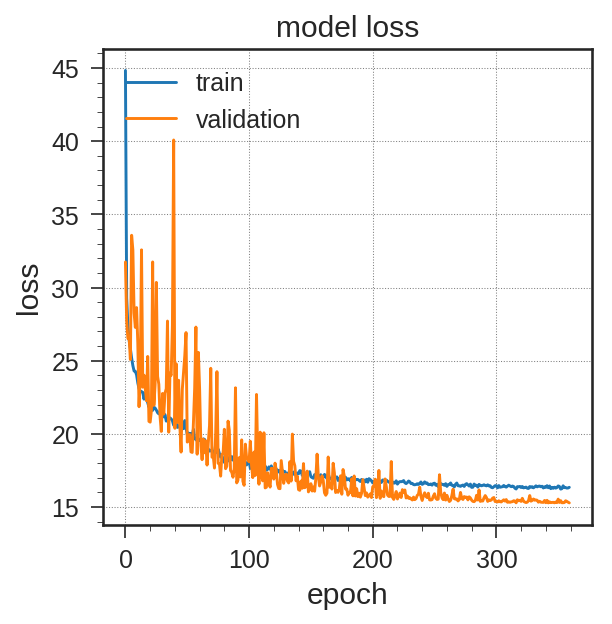

In [15]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

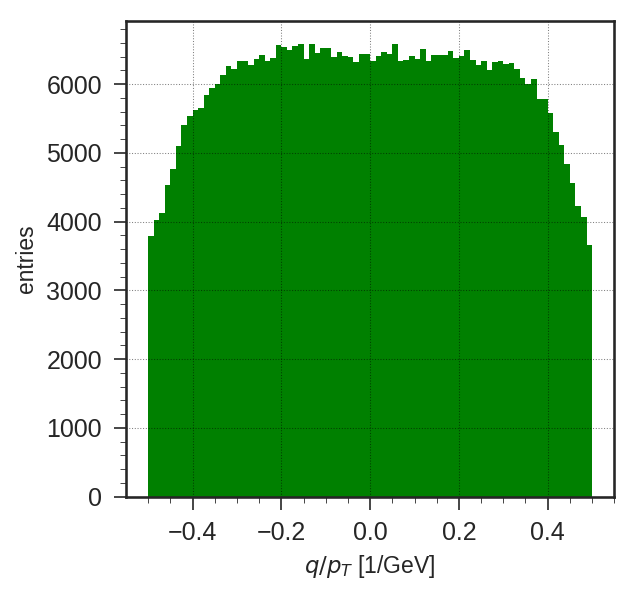

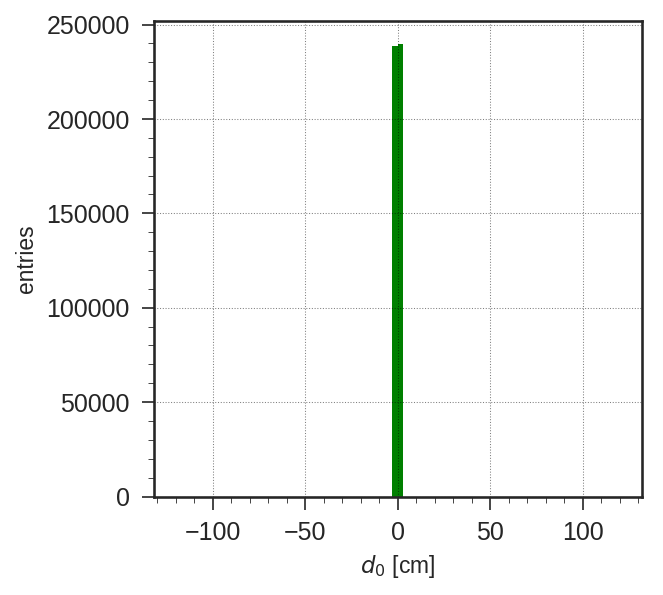

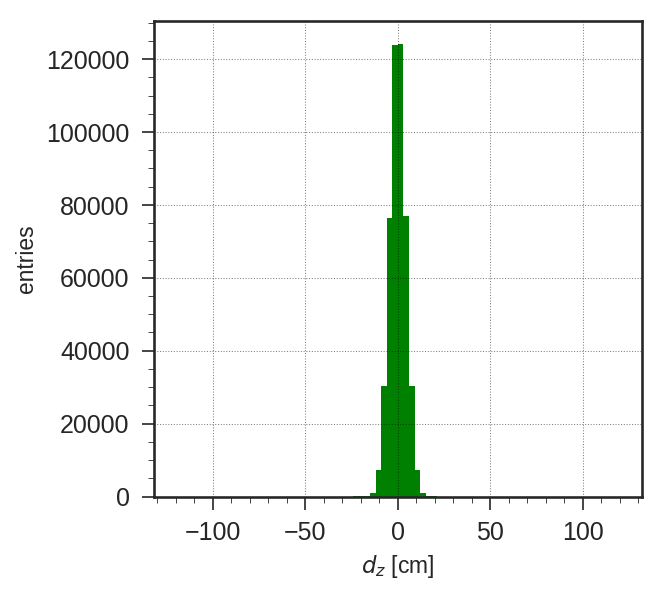

In [16]:
# Plot q/pT, d0, dz - no_displ

plt.figure()
plt.hist(y_test/reg_pt_scale, bins=80, range=(-0.5,0.5), color='g')
plt.xlabel(r'$q/p_{T}$ [1/GeV]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dxy_test/reg_dxy_scale, bins=80, range=(-120,120), color='g')
#plt.xlabel(r'$d_{xy}$ [cm]', fontsize=11)
plt.xlabel(r'$d_{0}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dz_test, bins=80, range=(-120,120), color='g')
plt.xlabel(r'$d_{z}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.show()

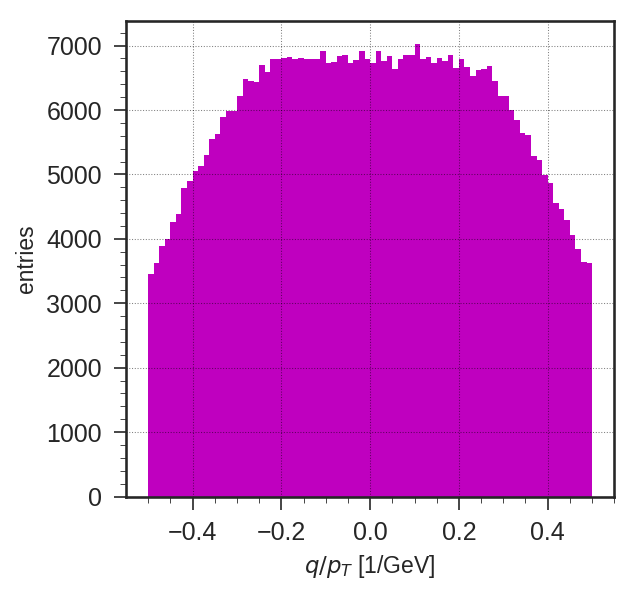

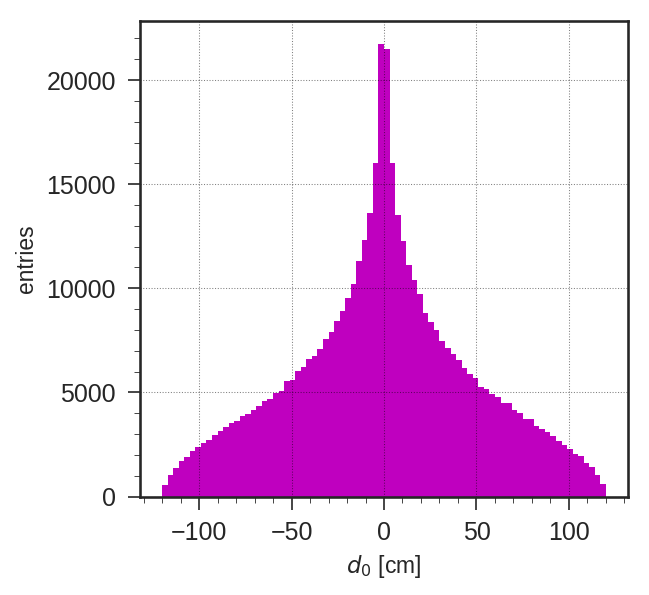

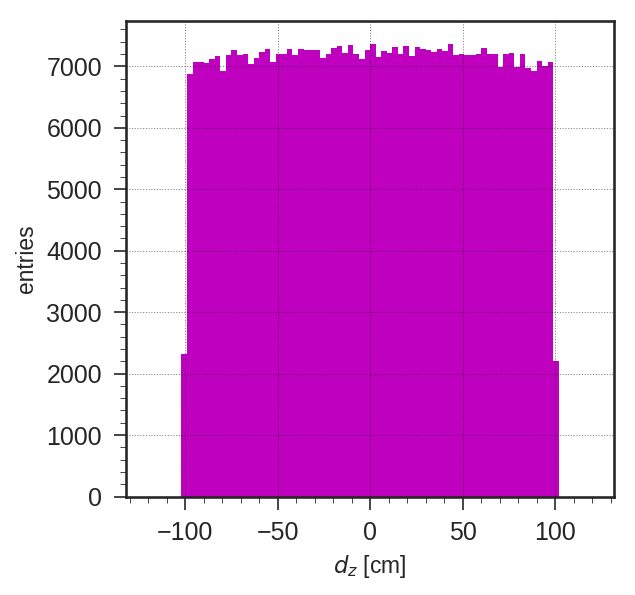

In [17]:
# Plot q/pT, d0, dz - displ

plt.figure()
plt.hist(y_test_displ/reg_pt_scale, bins=80, range=(-0.5,0.5), color='m')
plt.xlabel(r'$q/p_{T}$ [1/GeV]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dxy_test_displ/reg_dxy_scale, bins=80, range=(-120,120), color='m')
#plt.xlabel(r'$d_{xy}$ [cm]', fontsize=11)
plt.xlabel(r'$d_{0}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dz_test_displ, bins=80, range=(-120,120), color='m')
plt.xlabel(r'$d_{z}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.show()

In [18]:
# Predictions

y_test_true = y_test.copy()
y_test_true /= reg_pt_scale

y_test_sel = (np.abs(1.0/y_test) >= 20./reg_pt_scale)

y_test_meas = model.predict(x_test, batch_size=4096)
y_test_meas /= reg_pt_scale
y_test_meas = y_test_meas.reshape(-1)

y_test_meas_check = model_displ.predict(x_test, batch_size=4096)
y_test_meas_check /= reg_pt_scale
y_test_meas_check = y_test_meas_check.reshape(-1)

y_test_true_displ = y_test_displ.copy()
y_test_true_displ /= reg_pt_scale

y_test_sel_displ = (np.abs(1.0/y_test_displ) >= 20./reg_pt_scale)

y_test_meas_displ = model_displ.predict(x_test_displ, batch_size=4096)
y_test_meas_displ /= reg_pt_scale
y_test_meas_displ = y_test_meas_displ.reshape(-1)

y_test_meas_check_displ = model.predict(x_test_displ, batch_size=4096)
y_test_meas_check_displ /= reg_pt_scale
y_test_meas_check_displ = y_test_meas_check_displ.reshape(-1)

dxy_test_true = dxy_test.copy()
dxy_test_true /= reg_dxy_scale

dxy_test_true_displ = dxy_test_displ.copy()
dxy_test_true_displ /= reg_dxy_scale

In [19]:
print y_test_true.shape, y_test_meas.shape, y_test_meas_check.shape
print y_test_true_displ.shape, y_test_meas_displ.shape, y_test_meas_check_displ.shape

(478800,) (478800,) (478800,)
(478800,) (478800,) (478800,)


[INFO    ] # of entries: 51240, mean: 0.000884193344973, std: 0.0349162444472
[INFO    ] gaus fit (a, mu, sig): [6.29898864e+03 4.28110134e-04 1.36370319e-02]


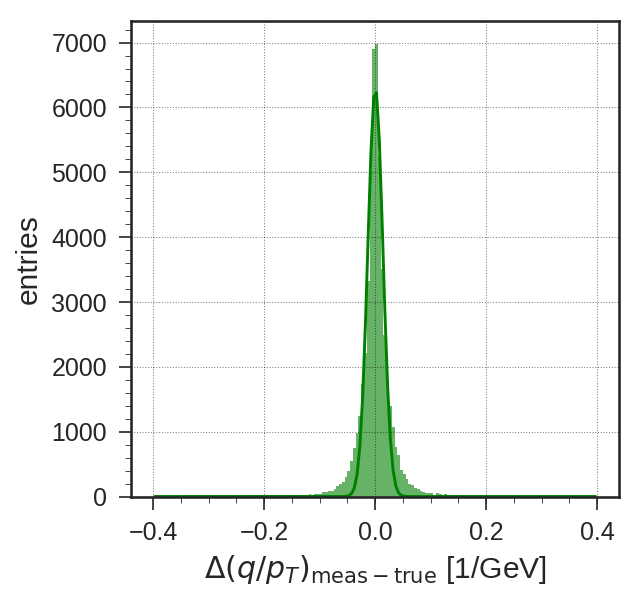

In [20]:
# Plot Delta(q/pT) - (a)

plt.figure()
yy = (y_test_meas - y_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 54454, mean: 0.0028863796033, std: 0.0822858884931
[INFO    ] gaus fit (a, mu, sig): [2.45177700e+03 2.73505806e-03 3.69088456e-02]


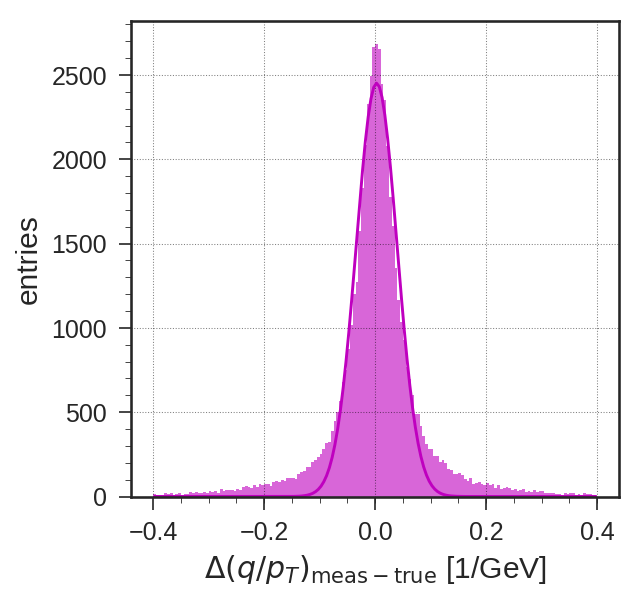

In [21]:
# Plot Delta(q/pT) - (b)

plt.figure()
yy = (y_test_meas_displ - y_test_true_displ)[y_test_sel_displ]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

[INFO    ] # of entries: 51240, mean: 0.00515779014677, std: 0.0687352716923
[INFO    ] gaus fit (a, mu, sig): [2.65077829e+03 4.01372755e-03 3.36840709e-02]


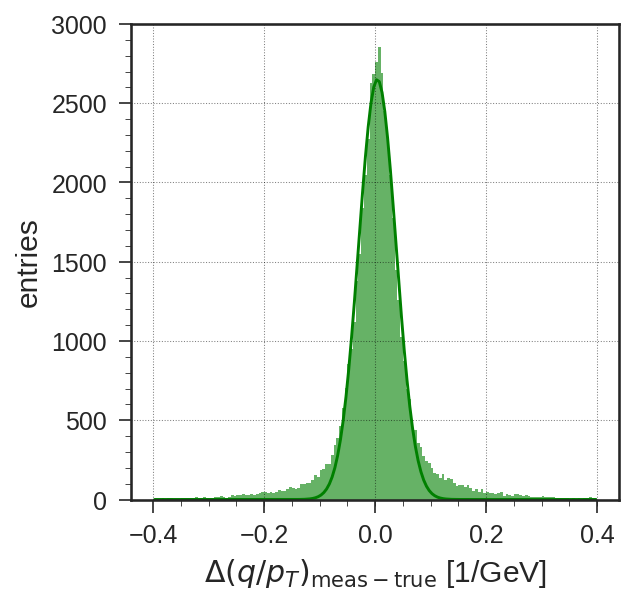

In [22]:
# Plot Delta(q/pT) - (c)

plt.figure()
yy = (y_test_meas_check - y_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 54454, mean: 0.00382900843397, std: 0.175179362297
[INFO    ] gaus fit (a, mu, sig): [5.49167682e+02 4.68884712e-03 1.85083305e-01]


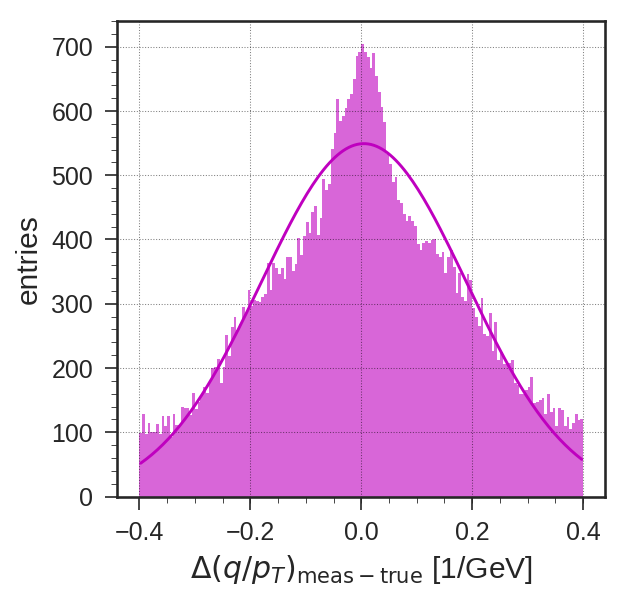

In [23]:
# Plot Delta(q/pT) - (d)

plt.figure()
yy = (y_test_meas_check_displ - y_test_true_displ)[y_test_sel_displ]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

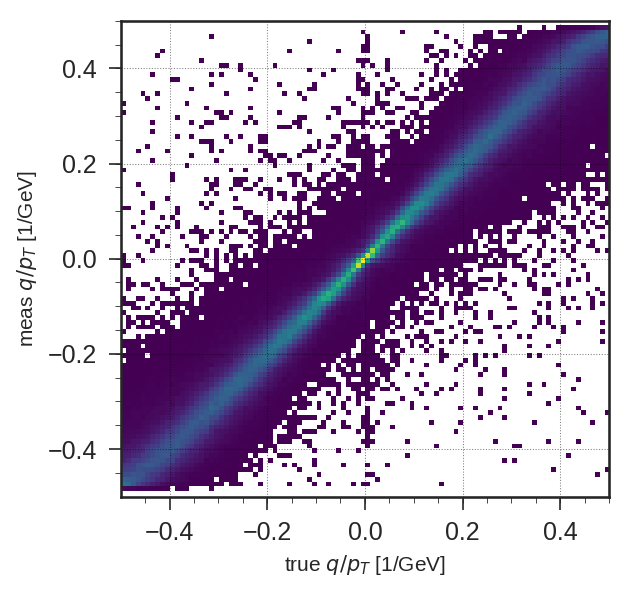

In [24]:
# Scatter plot - (a)

plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

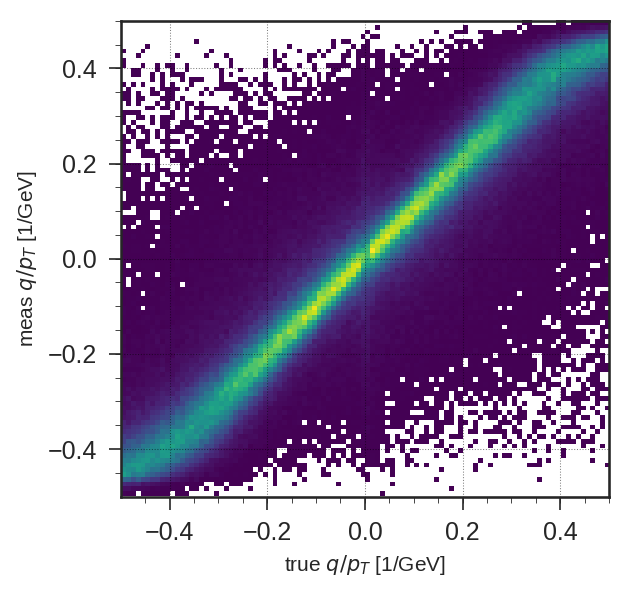

In [25]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(y_test_true_displ, y_test_meas_displ, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

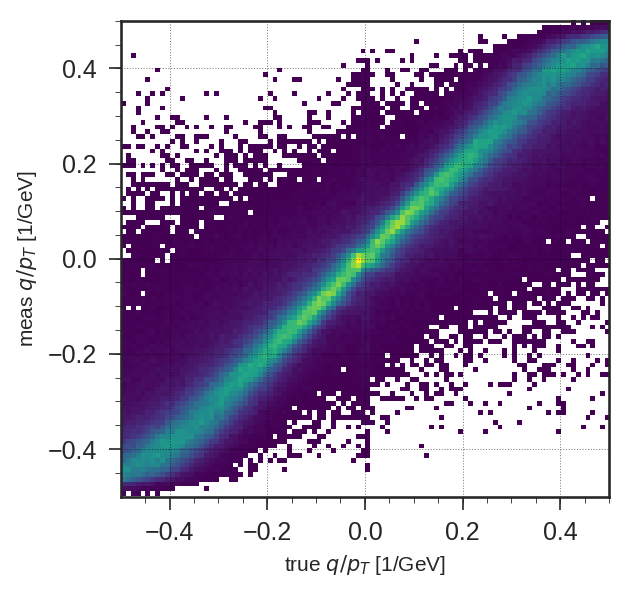

In [26]:
# Scatter plot - (c)

plt.figure()
plt.hist2d(y_test_true, y_test_meas_check, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

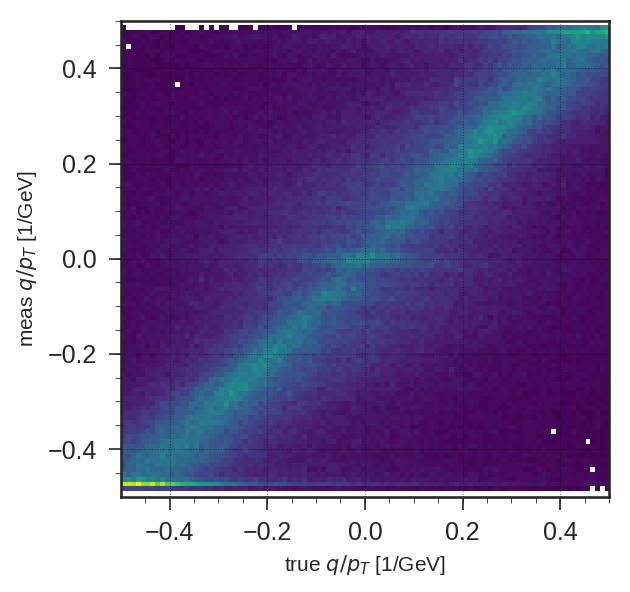

In [27]:
# Scatter plot - (d)

plt.figure()
plt.hist2d(y_test_true_displ, y_test_meas_check_displ, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

In [28]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = ((y_test_meas) - (y_test_true))
#yy = ((y_test_meas) - (y_test_true))/np.abs(y_test_true)
#yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 50
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx0 = np.zeros(nbinsx, dtype=np.float32)
yyy0 = np.zeros(nbinsx, dtype=np.float32)
zzz0 = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i] * pt
  #yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-0.6,0.6))  #FIXME
  #hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 24.:
    xx0_20GeV, yy0_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx0[i] = pt
  yyy0[i] = popt[2]
  zzz0[i] = popt[1]

In [29]:
# Make better resolution plot
xx = np.abs(y_test_true_displ)
yy = ((y_test_meas_displ) - (y_test_true_displ))
#yy = ((y_test_meas_displ) - (y_test_true_displ))/np.abs(y_test_true_displ)
#yy = (np.abs(1.0/y_test_meas_displ) - np.abs(1.0/y_test_true_displ))/np.abs(1.0/y_test_true_displ)

nbinsx = 50
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i] * pt
  #yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-1.2,1.2))  #FIXME
  #hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.6)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 24.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
    
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): [1.15415795e+02 1.71510504e-02 3.45383798e-01]
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


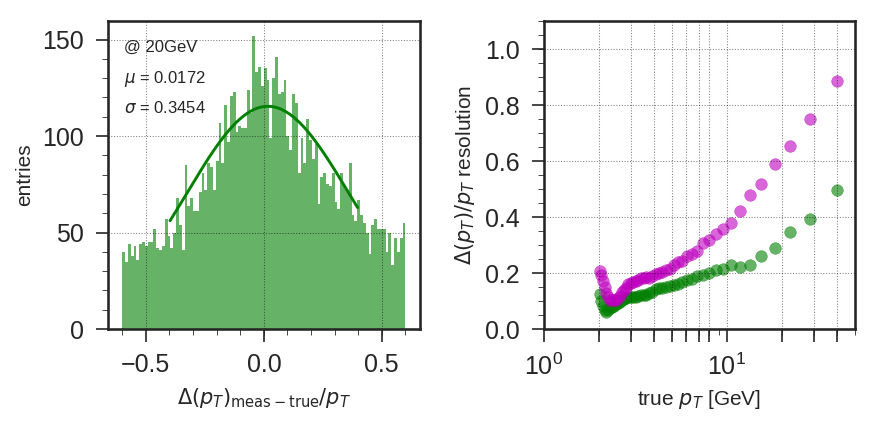

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy0_20GeV, bins=100, range=(-0.6,0.6), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
#hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-1.2,1.2), histtype='stepfilled', facecolor='m', alpha=0.6)
#popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
#axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx0, yyy0, color='g', alpha=0.6)
axs[1].scatter(xxx, yyy, color='m', alpha=0.6)
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,1.1+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

In [31]:
# Make better resolution plot
xx = (dxy_test_true)
#yy = ((y_test_meas) - (y_test_true))
yy = ((y_test_meas) - (y_test_true))/np.abs(y_test_true)
#yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

xx = xx[y_test_sel]
yy = yy[y_test_sel]
#xx = xx[(20 < np.abs(1.0/y_test_true)) & (np.abs(1.0/y_test_true) < 40)]
#yy = yy[(20 < np.abs(1.0/y_test_true)) & (np.abs(1.0/y_test_true) < 40)]

nbinsx = 30-1
xedges = np.linspace(-150, 150, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx0 = np.zeros(nbinsx, dtype=np.float32)
yyy0 = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  #pt = 1.0/pt
  if xx_i.size < 100:
    continue
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=50, range=(-0.6,0.6))  #FIXME
  #hist, edges = np.histogram(yy_i, bins=50, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 24.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx0[i] = pt
  yyy0[i] = popt[2]

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-numpy/1.15.1/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-numpy/1.15.1/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [32]:
# Make better resolution plot
xx = (dxy_test_true_displ)
#yy = ((y_test_meas_displ) - (y_test_true_displ))
yy = ((y_test_meas_displ) - (y_test_true_displ))/np.abs(y_test_true_displ)
#yy = (np.abs(1.0/y_test_meas_displ) - np.abs(1.0/y_test_true_displ))/np.abs(1.0/y_test_true_displ)

xx = xx[y_test_sel_displ]
yy = yy[y_test_sel_displ]
#xx = xx[(20 < np.abs(1.0/y_test_true_displ)) & (np.abs(1.0/y_test_true_displ) < 40)]
#yy = yy[(20 < np.abs(1.0/y_test_true_displ)) & (np.abs(1.0/y_test_true_displ) < 40)]

nbinsx = 30-1
xedges = np.linspace(-150, 150, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  #pt = 1.0/pt
  if xx_i.size < 100:
    continue
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  #hist, edges = np.histogram(yy_i, bins=50, range=(-1.2,1.2))  #FIXME
  hist, edges = np.histogram(yy_i, bins=50, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.6)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 24.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [8.40539957e+01 6.67115453e-02 6.97658679e-01]


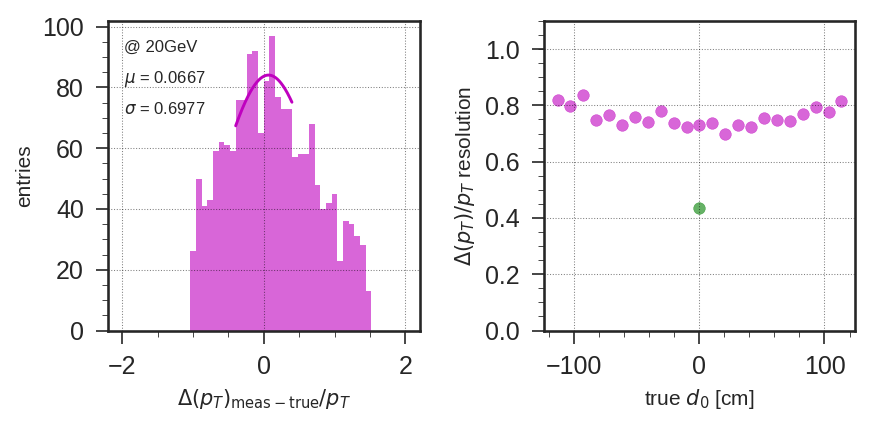

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=50, range=(-2,2), histtype='stepfilled', facecolor='m', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx0[yyy0 > 1e-6], yyy0[yyy0 > 1e-6], color='g', alpha=0.6)
axs[1].scatter(xxx[yyy > 1e-6], yyy[yyy > 1e-6], color='m', alpha=0.6)
#axs[1].set_xlim(1,50)
axs[1].set_ylim(0,1.1+eps)
axs[1].set_xlabel(r'true $d_{0}$ [cm]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
#axs[1].set_xscale('log')
#axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

### Training (Part II)

Try different cases:
- (a) Train with d0 only
- (b) Train with pT & d0, check pT & d0 resolution

In [34]:
model_d0 = create_model_sequential_bn3(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=30, nodes2=25, nodes3=20)

modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 36)                144       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1080      
_________________________________________________________________
batch_normalization_10 (Batc (None, 30)                120       
_________________________________________________________________
activation_7 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                750       
_________________________________________________________________
batch_normalization_11 (Batc (None, 25)                100       
_________________________________________________________________
activation_8 (Activation)    (None, 25)                0         
__________

In [35]:
logger.info('Begin training ...')
history = model_d0.fit(x_train_displ, dxy_train_displ/reg_dxy_scale,
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

model_d0.load_weights('model_bchk_weights.h5')

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 360/360 - loss: 39.4853322849 - val_loss: 38.4211313451


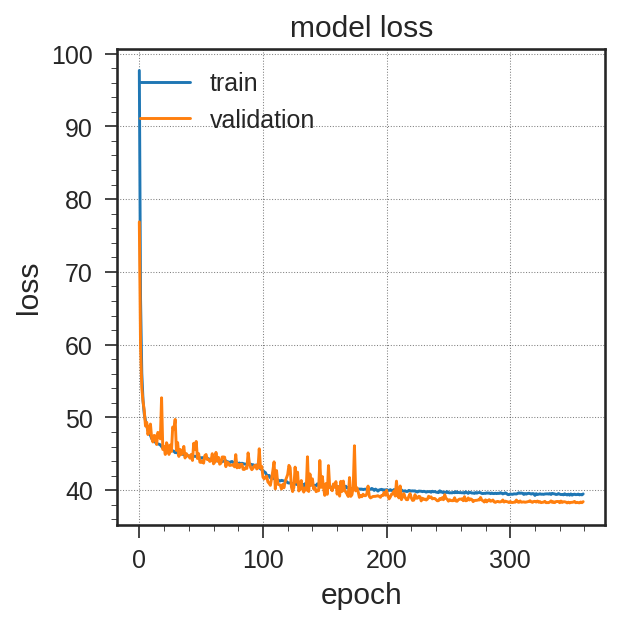

In [36]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
model_y_d0 = create_model_sequential_bn3(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=30, nodes2=25, nodes3=20, outnodes=2)

modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 36)                144       
_________________________________________________________________
dense_13 (Dense)             (None, 30)                1080      
_________________________________________________________________
batch_normalization_14 (Batc (None, 30)                120       
_________________________________________________________________
activation_10 (Activation)   (None, 30)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 25)                750       
_________________________________________________________________
batch_normalization_15 (Batc (None, 25)                100       
_________________________________________________________________
activation_11 (Activation)   (None, 25)                0         
__________

In [38]:
logger.info('Begin training ...')
history = model_y_d0.fit(x_train_displ, np.column_stack((y_train_displ, dxy_train_displ)),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

model_y_d0.load_weights('model_bchk_weights.h5')

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 360/360 - loss: 15.7079204722 - val_loss: 14.8282989323


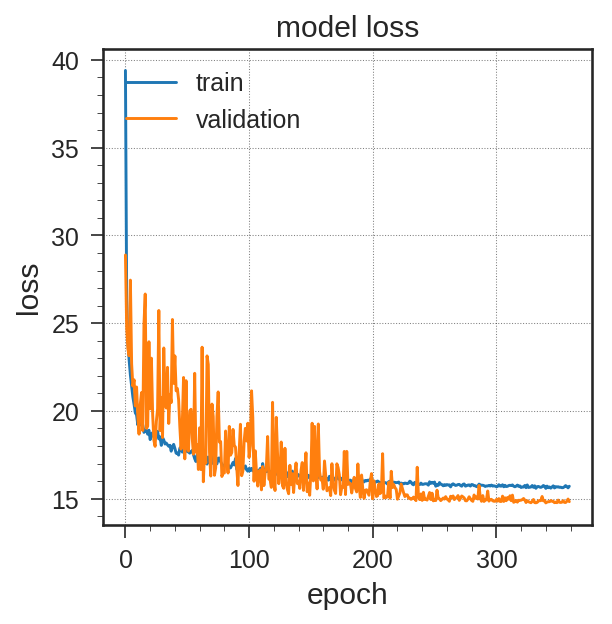

In [39]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
# Predictions

y_test_true = y_test_displ.copy()
y_test_true /= reg_pt_scale

y_test_sel = (np.abs(1.0/y_test_displ) >= 20./reg_pt_scale)

y_test_meas_ = model_y_d0.predict(x_test_displ, batch_size=4096)
y_test_meas = y_test_meas_[:,0]
y_test_meas /= reg_pt_scale
y_test_meas = y_test_meas.reshape(-1)

dxy_test_true = dxy_test_displ.copy()
dxy_test_true /= reg_dxy_scale

dxy_test_meas = y_test_meas_[:,1]
dxy_test_meas /= reg_dxy_scale
dxy_test_meas = dxy_test_meas.reshape(-1)

dxy_test_meas_check = model_d0.predict(x_test_displ, batch_size=4096)
#dxy_test_meas_check /= reg_dxy_scale
dxy_test_meas_check = dxy_test_meas_check.reshape(-1)

In [41]:
print y_test_true.shape, y_test_meas.shape, dxy_test_true.shape, dxy_test_meas.shape, dxy_test_meas_check.shape

(478800,) (478800,) (478800,) (478800,) (478800,)


[INFO    ] # of entries: 54454, mean: -0.142252862453, std: 12.4265966415
[INFO    ] gaus fit (a, mu, sig): [5.71547724e+03 5.11204647e-02 6.65732310e+00]


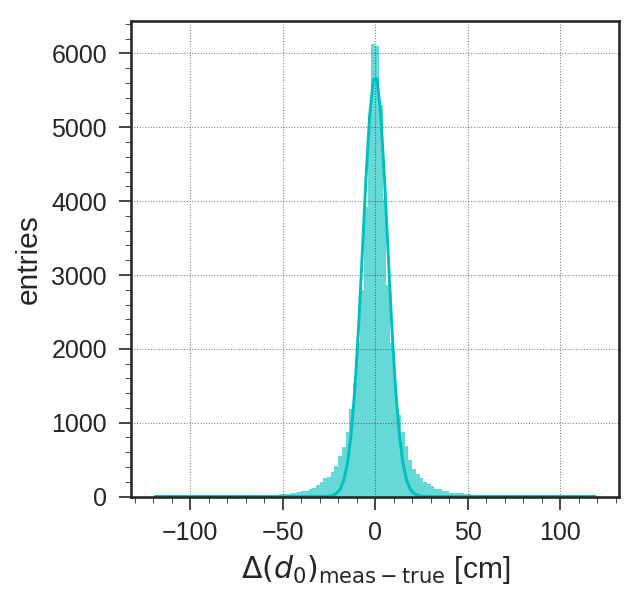

In [42]:
# Plot Delta(dxy) - (a)

plt.figure()
yy = (dxy_test_meas_check - dxy_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=120, range=(-120,120), histtype='stepfilled', facecolor='c', alpha=0.6)
#plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<20]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')
plt.show()

[INFO    ] # of entries: 54454, mean: 0.171668916941, std: 12.8421621323
[INFO    ] gaus fit (a, mu, sig): [6.63148984e+03 1.56724670e-01 5.46070464e+00]


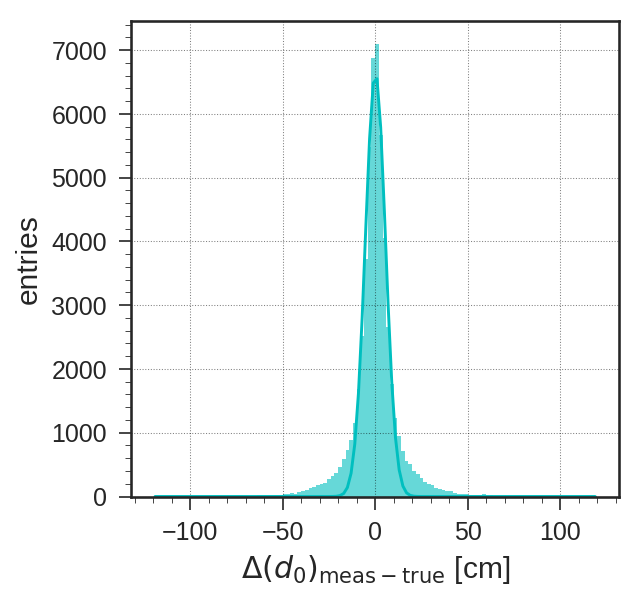

In [43]:
# Plot Delta(dxy) - (b)

plt.figure()
yy = (dxy_test_meas - dxy_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=120, range=(-120,120), histtype='stepfilled', facecolor='c', alpha=0.6)
#plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<20]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')
plt.show()

[INFO    ] # of entries: 54454, mean: 0.000531458819751, std: 0.0882302373648
[INFO    ] gaus fit (a, mu, sig): [2.43713768e+03 7.28457632e-04 3.58625617e-02]


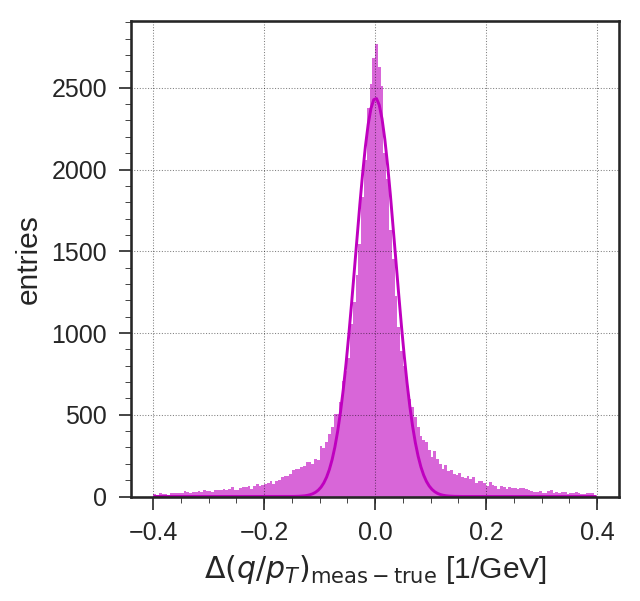

In [44]:
# Plot Delta(q/pT) - (b)

plt.figure()
yy = (y_test_meas - y_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

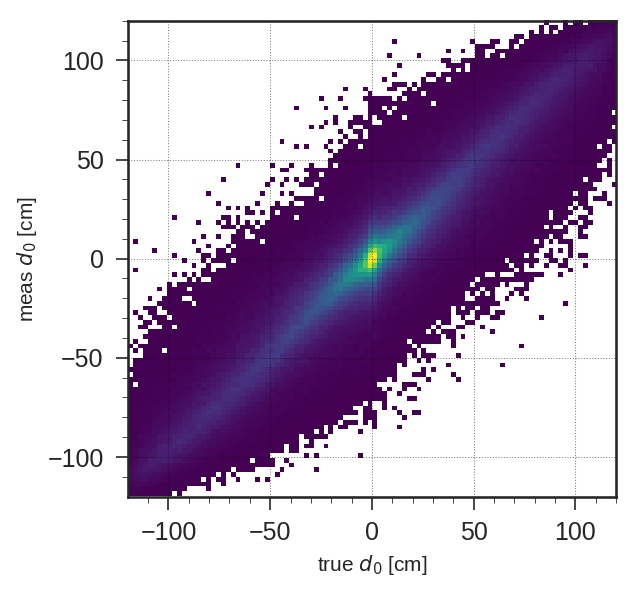

In [45]:
# Scatter plot - (a)

plt.figure()
plt.hist2d(dxy_test_true, dxy_test_meas_check, bins=(100,100), range=((-120,120),(-120,120)), vmin=1, cmap=my_cmap)
#plt.xlabel(r'true $d_{xy}$ [cm]', fontsize=10)
#plt.ylabel(r'meas $d_{xy}$ [cm]', fontsize=10)
plt.xlabel(r'true $d_{0}$ [cm]', fontsize=10)
plt.ylabel(r'meas $d_{0}$ [cm]', fontsize=10)
plt.show()

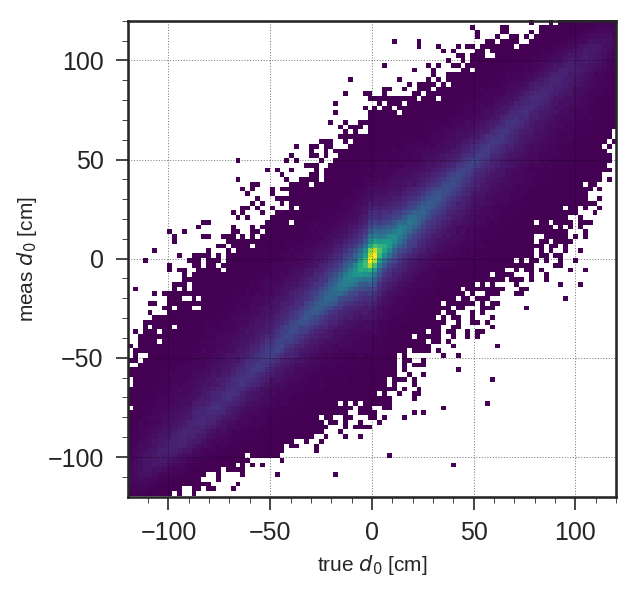

In [46]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(dxy_test_true, dxy_test_meas, bins=(100,100), range=((-120,120),(-120,120)), vmin=1, cmap=my_cmap)
#plt.xlabel(r'true $d_{xy}$ [cm]', fontsize=10)
#plt.ylabel(r'meas $d_{xy}$ [cm]', fontsize=10)
plt.xlabel(r'true $d_{0}$ [cm]', fontsize=10)
plt.ylabel(r'meas $d_{0}$ [cm]', fontsize=10)
plt.show()

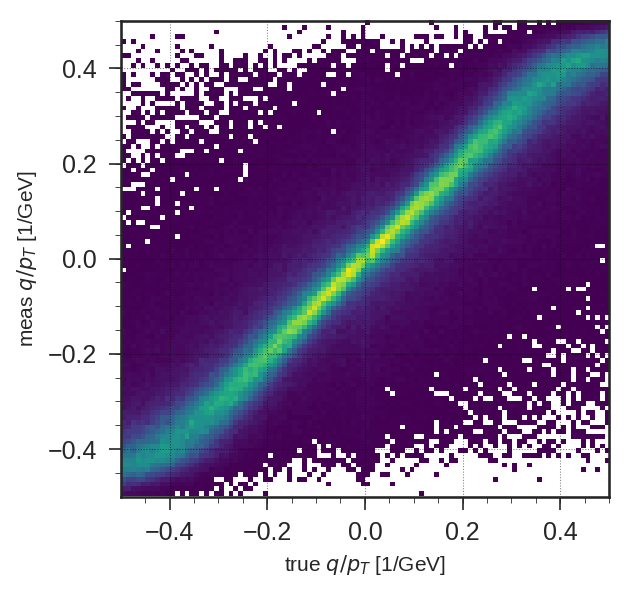

In [47]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

In [48]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (dxy_test_meas - dxy_test_true)

nbinsx = 50
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  #yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  #assert(np.abs(mu) < 1)
  #assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-50,50))
  popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  #popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 24.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): [6.54615235e+02 1.38106761e-01 5.72101381e+00]


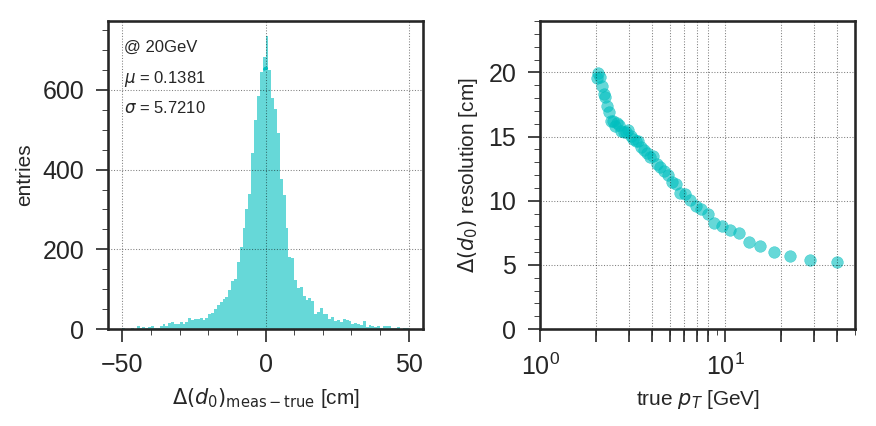

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-50,50), histtype='stepfilled', facecolor='c', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='c', alpha=0.6)
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,24+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(d_{0})$ resolution [cm]', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

In [50]:
# Make better resolution plot
xx = (dxy_test_true)
yy = (dxy_test_meas - dxy_test_true)

xx = xx[y_test_sel]
yy = yy[y_test_sel]
#xx = xx[(20 < np.abs(1.0/y_test_true)) & (np.abs(1.0/y_test_true) < 40)]
#yy = yy[(20 < np.abs(1.0/y_test_true)) & (np.abs(1.0/y_test_true) < 40)]

nbinsx = 30-1
xedges = np.linspace(-150, 150, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  #pt = 1.0/pt
  if xx_i.size < 100:
    continue
  
  yy_i = yy[inds==i]
  #yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  #assert(np.abs(mu) < 1)
  #assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-50,50))
  popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  #popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 24.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [243.47475684  -1.15886016   4.90546   ]


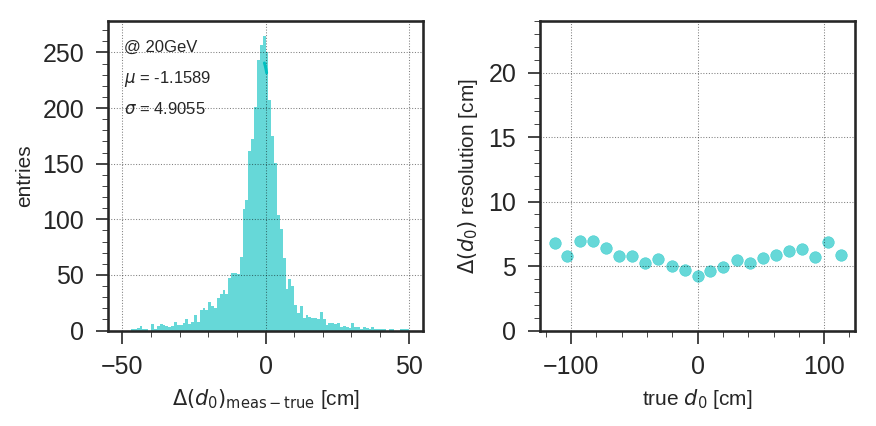

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-50,50), histtype='stepfilled', facecolor='c', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx[yyy > 1e-6], yyy[yyy > 1e-6], color='c', alpha=0.6)
#axs[1].set_xlim(1,50)
axs[1].set_ylim(0,24+eps)
axs[1].set_xlabel(r'true $d_{0}$ [cm]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(d_{0})$ resolution [cm]', fontsize=10)
#axs[1].set_xscale('log')
#axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

### Training (Part III)

Try different cases:
- (a) Train with pT & d0, for reg_dxy_scale = 0.05
- (b) Train with pT & d0, for reg_dxy_scale = 0.1
- (c) Train with pT & d0, for reg_dxy_scale = 0.2
- (d) Train with pT & d0, for reg_dxy_scale = 0.5
- (e) Train with pT & d0, for reg_dxy_scale = 1.0
- (f) Train with pT & d0, for reg_dxy_scale = 5.0

In [52]:
def part3_training():
  model_y_d0_1 = create_model_sequential_bn3(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=30, nodes2=25, nodes3=20, outnodes=2)
  
  modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
  modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)

  logger.info('Begin training ...')
  history = model_y_d0_1.fit(x_train_displ, np.column_stack((y_train_displ, dxy_train_displ / reg_dxy_scale * reg_dxy_scale_1)),
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
  logger.info('Done training.')
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
      len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))
  
  model_y_d0_1.load_weights('model_bchk_weights.h5')

  plt.figure(figsize=(3,3))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  #plt.show()
  
  # Predictions
  y_test_true = y_test_displ.copy()
  y_test_true /= reg_pt_scale
  
  y_test_sel = (np.abs(1.0/y_test_displ) >= 20./reg_pt_scale)

  y_test_meas_ = model_y_d0_1.predict(x_test_displ, batch_size=4096)
  y_test_meas = y_test_meas_[:,0]
  y_test_meas /= reg_pt_scale
  y_test_meas = y_test_meas.reshape(-1)

  dxy_test_true = dxy_test_displ.copy()
  dxy_test_true /= reg_dxy_scale

  dxy_test_meas = y_test_meas_[:,1]
  dxy_test_meas /= reg_dxy_scale_1
  dxy_test_meas = dxy_test_meas.reshape(-1)
  
  # Plot
  plt.figure(figsize=(3,3))
  yy = (dxy_test_meas - dxy_test_true)[y_test_sel]
  hist, edges, _ = plt.hist(yy, bins=120, range=(-120,120), histtype='stepfilled', facecolor='c', alpha=0.6)
  #plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
  plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
  plt.ylabel(r'entries')
  logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

  popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<20]))
  logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
  xdata = (edges[1:] + edges[:-1])/2
  plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')

  plt.figure(figsize=(3,3))
  yy = (y_test_meas - y_test_true)[y_test_sel]
  hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
  plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
  plt.ylabel(r'entries')
  logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

  popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
  logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
  xdata = (edges[1:] + edges[:-1])/2
  plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')

  plt.figure(figsize=(3,3))
  plt.hist2d(dxy_test_true, dxy_test_meas, bins=(100,100), range=((-120,120),(-120,120)), vmin=1, cmap=my_cmap)
  #plt.xlabel(r'true $d_{xy}$ [cm]', fontsize=10)
  #plt.ylabel(r'meas $d_{xy}$ [cm]', fontsize=10)
  plt.xlabel(r'true $d_{0}$ [cm]', fontsize=10)
  plt.ylabel(r'meas $d_{0}$ [cm]', fontsize=10)
  #plt.show()

  plt.figure(figsize=(3,3))
  plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
  plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
  plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
  plt.show()

### Training (Part IV)

Try different cases:

- (a) Train with pT in -1 < d0 < 1
- (b) Train with pT in -10 < d0 < 10
- (c) Train with pT in -60 < d0 < -40

In [53]:
def part4_training():
  small_epochs = 200
  
  model_y_d0cut = create_model_sequential_bn3(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=30, nodes2=25, nodes3=20)
  
  modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
  modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)
  
  logger.info('Begin training ...')
  
  dxy_train_sel = (dxy_low*reg_dxy_scale < dxy_train_displ) & (dxy_train_displ < dxy_high*reg_dxy_scale)
  dxy_test_sel = (dxy_low*reg_dxy_scale < dxy_test_displ) & (dxy_test_displ < dxy_high*reg_dxy_scale)
  #dxy_train_sel = dxy_train_sel & (np.abs(dz_train_displ) < 10.)
  #dxy_test_sel = dxy_test_sel & (np.abs(dz_test_displ) < 10.)
  
  history = model_y_d0cut.fit(x_train_displ[dxy_train_sel], y_train_displ[dxy_train_sel],
                      epochs=small_epochs, batch_size=batch_size,
                      callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
  logger.info('Done training.')
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
      len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))
  
  model_y_d0cut.load_weights('model_bchk_weights.h5')

  plt.figure(figsize=(3,3))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  #plt.show()
  
  # Predictions
  y_test_true = y_test_displ.copy()[dxy_test_sel]
  y_test_true /= reg_pt_scale
  
  y_test_sel = (np.abs(1.0/y_test_displ[dxy_test_sel]) >= 20./reg_pt_scale)

  y_test_meas = model_y_d0cut.predict(x_test_displ[dxy_test_sel], batch_size=4096)
  y_test_meas /= reg_pt_scale
  y_test_meas = y_test_meas.reshape(-1)
  
  # Plot
  plt.figure(figsize=(3,3))
  yy = (y_test_meas - y_test_true)[y_test_sel]
  hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
  plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
  plt.ylabel(r'entries')
  logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

  popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
  logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
  xdata = (edges[1:] + edges[:-1])/2
  plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')

  plt.figure(figsize=(3,3))
  plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
  plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
  plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

  plt.show()

### Training (Part V)

Try different cases:

- (a) Train with pT in -1 < vz < 1
- (b) Train with pT in -10 < vz < 10
- (b) Train with pT in -30 < vz < 30

In [54]:
def part5_training():
  small_epochs = 200
  
  model_y_vzcut = create_model_sequential_bn3(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=30, nodes2=25, nodes3=20)
  
  modelbestcheck = ModelCheckpoint(filepath='model_bchk.h5', monitor='val_loss', verbose=0, save_best_only=True)
  modelbestcheck_weights = ModelCheckpoint(filepath='model_bchk_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)
  
  logger.info('Begin training ...')
  
  vz_train_sel = (vz_low < dz_train_displ) & (dz_train_displ < vz_high)
  vz_test_sel = (vz_low < dz_test_displ) & (dz_test_displ < vz_high)
  
  history = model_y_vzcut.fit(x_train_displ[vz_train_sel], y_train_displ[vz_train_sel],
                      epochs=small_epochs, batch_size=batch_size,
                      callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=0)
  logger.info('Done training.')
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
      len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))
  
  model_y_vzcut.load_weights('model_bchk_weights.h5')

  plt.figure(figsize=(3,3))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  #plt.show()
  
  # Predictions
  y_test_true = y_test_displ.copy()[vz_test_sel]
  y_test_true /= reg_pt_scale
  
  y_test_sel = (np.abs(1.0/y_test_displ[vz_test_sel]) >= 20./reg_pt_scale)

  y_test_meas = model_y_vzcut.predict(x_test_displ[vz_test_sel], batch_size=4096)
  y_test_meas /= reg_pt_scale
  y_test_meas = y_test_meas.reshape(-1)
  
  # Plot
  plt.figure(figsize=(3,3))
  yy = (y_test_meas - y_test_true)[y_test_sel]
  hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
  plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
  plt.ylabel(r'entries')
  logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

  popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
  logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
  xdata = (edges[1:] + edges[:-1])/2
  plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')

  plt.figure(figsize=(3,3))
  plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
  plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
  plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

  plt.show()